# Implementação básica do algoritmo k-means

Em grande parte baseada na implementação disponível em [dataquestio/kmeans](https://github.com/dataquestio/project-walkthroughs/tree/master/kmeans)

## Imports e Variáveis Globais

In [4]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from IPython.display import clear_output



PLOT_RESULTS = True
DEBUG = True

N = 100000
D = 7

K = 5
MAX_ITERATIONS = 500

## Criando o Dataset

- `N` datapoints
- Datapoints `D`-dimensionais
- Floats randomizados ➡ intervalo de [1, 10) (ou [1, 10], dependendo da método de arredondamento de float usado. Isto não deve ter nenhuma relevância estatística, no entanto)

In [5]:
dataset  = [[np.random.uniform(1, 10) for _ in range(D)] for _ in range(N)]
dataset = pd.DataFrame(dataset, columns=[f'd{i}' for i in range(D)])
dataset

,d0,d1,d2,d3,d4,d5,d6
0,4.802996,9.346448,7.309811,6.537069,1.748368,6.190163,1.268672
1,5.573557,7.588241,1.703753,3.112669,3.999464,6.329684,6.133968
2,8.493676,5.914053,3.652147,2.268322,6.630816,9.433242,7.178932
3,3.418362,3.888936,2.906005,5.544236,8.515628,4.643878,2.424895
4,7.836578,6.492430,5.000379,1.337036,1.830696,3.205548,1.909999
...,...,...,...,...,...,...,...
99995,9.629777,6.628050,6.951005,2.960968,9.516643,9.186526,6.044228
99996,4.767566,3.751918,3.288392,2.833917,1.174735,6.875627,1.518920
99997,9.134283,3.076014,6.965917,3.204452,2.104454,5.440071,4.268759
99998,8.069904,9.833539,3.723380,3.421842,6.404110,7.920194,9.236610


## K-Means (CPU)

In [6]:
def kMeansCPU(dataset:pd.DataFrame, k=3, maxIter=100, plotResults=False, debug=False):
    if plotResults:
        # Inicializando variáveis para exibição gráfica
        pca = PCA(n_components=2) # dois eixos no gráfico
        dataset_2D = pca.fit_transform(dataset)

    # Gerando centróides iniciais randomicamente
    centroids = pd.concat([(dataset.apply(lambda x: float(x.sample().iloc[0]))) for _ in range(k)], axis=1) # * Paralelizar isto provavelmente é irrelevante, visto que sempre teremos poucos centróides
    centroids_OLD = pd.DataFrame()

    iteration = 1

    while iteration <= maxIter and not centroids_OLD.equals(centroids):
        if plotResults or debug: clear_output(wait=True)
        if debug: debugStr = f'Iteration {iteration}\n\nCentroids:\n{centroids.T}\n\n'

        # Para cada datapoint, calcular distâncias entre ele e cada centróide; depois, encontrar o centróide mais próximo e salvar seu index
        distances = centroids.apply(lambda x: np.sqrt(((dataset - x) ** 2).sum(axis=1))) # ! Parte altamente paralelizável!
        if debug: debugStr += f'Distances:\n{distances}\n\n'
        closestCent = distances.idxmin(axis=1)
        del distances
        if debug: debugStr += f'Closest centroid index:\n{closestCent}\n\n'

        centroids_OLD = centroids
        centroids = dataset.groupby(closestCent).apply(lambda x: np.exp(np.log(x).mean())).T # ! Parte altamente paralelizável!

        if plotResults:
            # Plotando clusters
            centroids_2D = pca.transform(centroids.T)
            plt.title(f'Iteration {iteration}')
            plt.scatter(x=dataset_2D[:,0], y=dataset_2D[:,1], c=closestCent)
            plt.scatter(x=centroids_2D[:,0], y=centroids_2D[:,1], marker='+', linewidths=2, color='red')
            plt.show()

        if debug: print(debugStr)

        iteration += 1

    return closestCent

In [7]:
# ! Descomente para rodar de fato
# result, centroids = kMeansCPU(dataset, K, MAX_ITERATIONS, PLOT_RESULTS, DEBUG)

# Testando com um Dataset Real (Pequeno) — *Iris*

Vamos agora testar esta implementação do k-means usando um dataset real de tamanho bem trivial.

Utilizaremos o [*Iris* Data Set](https://archive.ics.uci.edu/ml/datasets/Iris), que consiste de dados a respeito de espécimes de [flores do gênero Íris](https://pt.wikipedia.org/wiki/Iris_(g%C3%A9nero)), popularmente chamadas de **Lírios**.

## Dataset

O *Iris* consiste em **150 instâncias**, com dados multivariados de **quatro atributos**:

1. Comprimento da sépala em centímetros
2. Largura da sépala em centímetros
3. Comprimento da pétala em centímetros
4. Largura da pétala em centímetros

Há também um quinto atributo de **Classe**, o **tipo da planta**, que é o que esperamos predizer utilizando o algoritmo. Há **três classes** neste dataset:

- Iris Setosa
- Iris Versicolour
- Iris Virginica

Assim, temos nossas variáveis para execução do k-means:

- `N` = 150
- `D` = 4
- `K` = 3

### Carregando o Dataset

In [37]:
# Imports
from os.path import exists as os_path_exists
from urllib.request import urlopen



# Novas variáveis globais
MAX_ITERATIONS = 100
PLOT_RESULTS = True
DEBUG = True
# ? K será inferido pela quantidade de classes no dataset
# // K = 3



# Função auxiliar
def downloadFileIfNeeded(filePath, url):
    if not os_path_exists(filePath):
        with urlopen(url) as f:
            html = f.read().decode('utf-8')
        with open(filePath, 'w') as f:
            f.write(html)



datasetUrl = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
datasetFilePath = './iris.data'
columnNames = ['sepalLen', 'sepalWid', 'petalLen', 'petalWid', 'class']

# Baixando dataset diretamente da internet, se necessário
downloadFileIfNeeded(datasetFilePath, datasetUrl)

# Lendo dataset do arquivo
with open(datasetFilePath, 'r') as datasetFile:
    dataset = pd.read_csv(datasetFilePath, names=columnNames)

print(dataset)

     sepalLen  sepalWid  petalLen  petalWid           class
0         5.1       3.5       1.4       0.2     Iris-setosa
1         4.9       3.0       1.4       0.2     Iris-setosa
2         4.7       3.2       1.3       0.2     Iris-setosa
3         4.6       3.1       1.5       0.2     Iris-setosa
4         5.0       3.6       1.4       0.2     Iris-setosa
..        ...       ...       ...       ...             ...
145       6.7       3.0       5.2       2.3  Iris-virginica
146       6.3       2.5       5.0       1.9  Iris-virginica
147       6.5       3.0       5.2       2.0  Iris-virginica
148       6.2       3.4       5.4       2.3  Iris-virginica
149       5.9       3.0       5.1       1.8  Iris-virginica

[150 rows x 5 columns]


### Preparando o Dataset

In [38]:
# Transformando a coluna "class" em números (0, 1, …)
classFactorized = dataset['class'].factorize()
# Salvando os nomes de classe na ordem usada pelo .factorize()
classes = list(classFactorized[1])
# // # Sobrescrevendo a coluna do dataset pelos indexes obtidos
# // dataset['class'] = classFactorized[0]

print(f'##### Dataset #####\n{dataset}\n\n')

# Ignorando a coluna "class"
datasetTreated = dataset.drop(['class'], axis=1)
# Normalizando o dataset (normalização min-max), para que todos valores estejam no intervalo [1, 10]
datasetTreated = ((datasetTreated - datasetTreated.min()) / (datasetTreated.max() - datasetTreated.min())) * 9 + 1

print(f'##### Dataset (tratado e normalizado, intervalo [1, 10]) #####\n{datasetTreated}')

# Inferindo número de grupos pela quantidade de classes no dataset
K = len(classes)

##### Dataset #####
     sepalLen  sepalWid  petalLen  petalWid           class
0         5.1       3.5       1.4       0.2     Iris-setosa
1         4.9       3.0       1.4       0.2     Iris-setosa
2         4.7       3.2       1.3       0.2     Iris-setosa
3         4.6       3.1       1.5       0.2     Iris-setosa
4         5.0       3.6       1.4       0.2     Iris-setosa
..        ...       ...       ...       ...             ...
145       6.7       3.0       5.2       2.3  Iris-virginica
146       6.3       2.5       5.0       1.9  Iris-virginica
147       6.5       3.0       5.2       2.0  Iris-virginica
148       6.2       3.4       5.4       2.3  Iris-virginica
149       5.9       3.0       5.1       1.8  Iris-virginica

[150 rows x 5 columns]


##### Dataset (tratado e normalizado, intervalo [1, 10]) #####
     sepalLen  sepalWid  petalLen  petalWid
0        3.00     6.625  1.610169     1.375
1        2.50     4.750  1.610169     1.375
2        2.00     5.500  1.457627     1

## Rodando o K-Means

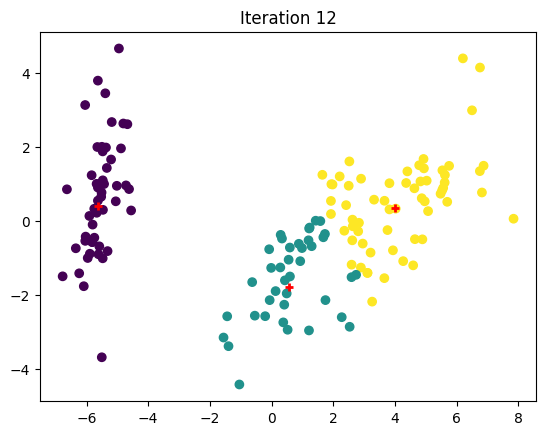

Iteration 12

Centroids:
   sepalLen  sepalWid  petalLen  petalWid
0  2.613660  6.143529  1.686990  1.494296
1  4.406264  3.218262  5.776541  5.361460
2  6.653880  4.714525  7.627264  7.778481

Distances:
             0         1          2
0     0.633408  6.843534   9.706222
1     1.405338  6.263432   9.719361
2     0.926038  6.748430  10.067004
3     1.342861  6.534070   9.980685
4     0.878785  7.091915   9.882999
..         ...       ...        ...
145  10.679365  5.181902   1.528083
146   9.518584  3.181035   2.021990
147   9.681312  4.126110   0.440030
148  10.310093  5.464731   2.312403
149   8.556487  2.989427   1.743136

[150 rows x 3 columns]

Closest centroid index:
0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Length: 150, dtype: int64




In [39]:
# Rodando kMeansCPU
results = kMeansCPU(datasetTreated, K, MAX_ITERATIONS, PLOT_RESULTS, DEBUG)

## Conferindo Resultados

Com a tabela `ClosestCentroids` em mãos, temos a classificação de cada instância do dataset *Iris* e, assim, podemos conferir os resultados obtidos através do k-means.

Para isto, basta comparar a segunda coluna da tabela devolvida pelo `kMeansCPU()` com a última coluna do dataset Iris, que informa a classe correta de cada instância.

Essa comparação, no entanto, não é tão simplória de se realizar. Não há como sabermos qual o mapeamento correto entre a classificação feita pelo k-means e as classes reais das instâncias do dataset. Isto é, não há como discernir se o `1` na coluna de classificação de centróides se refere a uma identificação de uma `Iris-versicolor` ao invés de uma `Iris-virginica`, por exemplo.

Por isso, temos que realizar o **maximum matching** atingido pelo resultado do k-means, para realizar uma avaliação justa de seu desempenho.

### Maximum Matching

Teremos que avaliar todas as possibilidades de *mapeamento centróide–classe* e considerar apenas aquela que gera o melhor resultado.

Para isso, é necessário calcular os acertos do resultado diversas vezes. Como há $ k! $ maneiras de se interpretar `K` centróides, isto irá gerar um custo computacional de $ n \cdot k! $ operações de comparação entre classificações.

In [95]:
from itertools import permutations

# print(f'result:\n{results}\n')
# print(f'dataset:\n{dataset}\n')
# print(f'classes:\n{classes}\n')

def getClassificationHits(results:pd.DataFrame, dataset:pd.DataFrame, classColumn:str|int='class', classes:list[str]=None, debug=False):
    '''Função auxiliar que retorna uma tupla com três informações: (1) a quantidade de acertos de classificação expressos no dataframe `results`; (2) as quantidades destes acertos separadas por classes; e (3) a interpretação das classes usadas para encontrar o melhor resultado
    
    Para determinar acertos e erros, é usada a coluna de nome/index `classColumn` do dataframe `dataset` como fonte de verdade. O maximum matching é feito para encontrar a melhor interpretação dos resultados e usá-la como resultado final

    `results` deve ser um dataframe com duas colunas, a primeira sendo o index do datapoint e a segunda sendo o index do da classe à qual o datapoint foi classificado
    
    Uma lista com os nomes das classes pode ser passada em `classes`, para agilizar o processo. Se nada for passado, as classes serão inferidas pela coluna de nome/index `classColumn` do dataframe `dataset`

    Centroid classes: 
Hits: 
Hits per class: 

    Exemplo de retorno: `(118, {'Iris-setosa': 35, 'Iris-versicolor': 39, 'Iris-virginica': 44}, ('Iris-virginica', 'Iris-setosa', 'Iris-versicolor'))`
    
    O retorno acima significa que houveram `118` acertos totais; sendo `35` desses da classe `Iris-setosa`, `39` da classe `Iris-versicolor` e `44` da classe `Iris-virginica`; e a interpretação usada para estes melhores resultados foi: classe `0` em `results` = `Iris-virginica`, classe `1` = `Iris-setosa` e  classe `2` = `Iris-versicolor`.'''

    if debug: print('#################### Computing classification hits... ####################\n')

    if classes is None or len(classes) == 0:
        classes = list(dataset[classColumn].factorize()[1])
        if debug: print(f'classes (inferred from `dataset`):\n{classes}\n')

    # Foçar classes para strings
    classes = [str(c) for c in classes]

    # Encontrar todas as permutações possíveis das classes. A posição de uma classe na permutação será usada para atrelar uma classe ao centroid de mesmo index. Por exemplo, na permutação ('Iris-versicolor', 'Iris-setosa', 'Iris-virginica'), o centróide 0 corresponderá à classe 'Iris-versicolor', o centróide 1 à classe 'Iris-setosa' e o centróide 2 à classse 'Iris-virginica'. Cada datapoint terá sua classificação definida através dessa relação
    classPerm = list(permutations(classes))

    if debug:
        print(f'classesPermutatons (len={len(classPerm)}):\n')
        for perm in classPerm: print(perm)
        print('\n')

    # Dicionário auxiliar que guarda a quantidade de acertos por classe e posição na lista de classes. Isto economizará poder computacional, pois não repetiremos cálculos redundantes de hits de uma classe numa mesma posição.
    # Estrutura:
    # {
    #     'Iris-setosa/0': 50,
    #     'Iris-setosa/1': 0,
    #     '<class>/<positionInPermutation>': 45,…
    # }
    hitsByclassAndPosition = {}

    bestHits = -1
    bestHitsPerClass = None
    bestPerm = None

    # Para cada permutação das classes
    for permutation in classPerm:
        print(f'permutation = {permutation}\n')
        hitsPerClass = dict.fromkeys(classes, -1)

        # Para cada classe na permutação atual
        for classPosition, class_ in enumerate(permutation):
            # Se os hits para essa classe nessa posição da permutação já foram computados, vamos usá-los. Se não, os computamos pela primeira vez e salvamos para usos posteriores
            classAndPositionStr = f'{class_}/{classPosition}' # Chave a ser usada no dicionário
            hits:int = hitsByclassAndPosition.get(classAndPositionStr, None)
            if hits is None:
                # TODO
                # TODO
                # TODO: Implementar o cálculo real dos acertos aqui
                # TODO
                # TODO
                hits:int = np.random.randint(0, 50 + 1)
                hitsByclassAndPosition[classAndPositionStr] = hits

            # Salvando a quantidade de acertos na classe atual, seja qual for
            hitsPerClass[class_] = hits
            print(f'classPosition = {classPosition}; class_ = {class_}\nhitsPerClass = {hitsPerClass}\nhitsByclassAndPosition = {hitsByclassAndPosition}\n')

        # Computar acertos totais dessa permutação
        totalHits = sum(hitsPerClass.values())

        if totalHits > bestHits:
            bestHits = totalHits
            bestHitsPerClass = hitsPerClass
            bestPerm = permutation

        print(f'totalHits = {totalHits}\nbestHits = {bestHits}; bestHitsPerClass = {bestHitsPerClass}; bestPerm = {bestPerm}\n\n\n')

    return (bestHits, bestHitsPerClass, bestPerm)



hits, hitsPerClass, centroidClasses  = getClassificationHits(results, dataset, classes=classes, debug=DEBUG)

if DEBUG: print(f'Centroid classes: {centroidClasses}\nHits: {hits}\nHits per class: {hitsPerClass}\n')

#################### Computing classification hits... ####################

classesPermutatons (len=6):

('Iris-setosa', 'Iris-versicolor', 'Iris-virginica')
('Iris-setosa', 'Iris-virginica', 'Iris-versicolor')
('Iris-versicolor', 'Iris-setosa', 'Iris-virginica')
('Iris-versicolor', 'Iris-virginica', 'Iris-setosa')
('Iris-virginica', 'Iris-setosa', 'Iris-versicolor')
('Iris-virginica', 'Iris-versicolor', 'Iris-setosa')


permutation = ('Iris-setosa', 'Iris-versicolor', 'Iris-virginica')

classPosition = 0; class_ = Iris-setosa
hitsPerClass = {'Iris-setosa': 26, 'Iris-versicolor': -1, 'Iris-virginica': -1}
hitsByclassAndPosition = {'Iris-setosa/0': 26}

classPosition = 1; class_ = Iris-versicolor
hitsPerClass = {'Iris-setosa': 26, 'Iris-versicolor': 45, 'Iris-virginica': -1}
hitsByclassAndPosition = {'Iris-setosa/0': 26, 'Iris-versicolor/1': 45}

classPosition = 2; class_ = Iris-virginica
hitsPerClass = {'Iris-setosa': 26, 'Iris-versicolor': 45, 'Iris-virginica': 15}
hitsByclassAndPosit